## benchmarking and profilinng
IMPORTANT: benchmark/profile your code!
You can read spec sheets (marketing material) and papers
...but performance depends on your library version, your hardware, your workload
...so there is no substitute for benchmarking/profiling your code.

Example computation: running forward/backward passes on an MLP.
    run_mlp(dim=128, num_layers=16, batch_size=128, num_steps=5)
 - benchmarking()       # How long does it take?
 - profiling()          # Where time is being spent?
    
<mark>Every time you make a change, benchmark/profile!</mark>




-----

## 性能基准测试与多层感知器 (MLP)

### 什么是性能基准测试？

**性能基准测试** (Benchmarking) 是一种衡量执行某项操作所需\*\*“挂钟时间” (wall-clock time)\*\* 的方法。它提供了端到端的时间消耗，但不会告诉你具体时间花在了哪里。要进行更细粒度的分析，需要使用性能剖析 (Profiling) 工具。

性能基准测试在以下场景中非常有用：

  * **比较不同实现**：找出哪种实现方式更快。
  * **理解性能扩展**：了解性能如何随参数（如维度、批量大小）的变化而变化。

-----

### MLP 模型定义

我们使用一个简单的多层感知器 (MLP) 模型进行测试。该模型由一系列线性层和 GeLU 激活函数交替组成。

```python
import torch.nn as nn

class MLP(nn.Module):
    """一个简单的MLP：线性 -> GeLU -> 线性 -> GeLU -> ... -> 线性 -> GeLU"""
    def __init__(self, dim: int, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(dim, dim) for _ in range(num_layers)])

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
            x = torch.nn.functional.gelu(x)
        return x
```

-----

### 基准测试函数

`benchmark` 函数用于对任意可调用函数进行计时。为了获得更准确的结果，它包含了**预热 (warmup)** 阶段和多次试验 (`num_trials`)。预热阶段可以避免由于编译和缓存未命中导致的初始运行时间较慢。

```python
import time
from typing import Callable
from statistics import mean

def benchmark(description: str, run: Callable, num_warmups: int = 1, num_trials: int = 3):
    """
    通过运行 `num_trials` 次来对 `func` 进行基准测试，并返回所有时间。
    - 预热：前几次运行可能会因为编译和缓存问题较慢，我们只关心稳定状态下的时间。
    - 在CUDA可用时，会调用 torch.cuda.synchronize() 来等待所有CUDA线程完成，
      这对于准确计时非常重要。
    """
    # 预热阶段
    for _ in range(num_warmups):
        run()
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    # 实际计时
    times: list[float] = []
    for trial in range(num_trials):
        start_time = time.time()
        run()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        end_time = time.time()
        times.append((end_time - start_time) * 1000) # 转换为毫秒

    mean_time = mean(times)
    return mean_time
```

-----

### 性能基准测试结果分析

我们对矩阵乘法和 MLP 模型在不同参数下的性能进行了基准测试。

#### 1\. 矩阵乘法

我们测试了不同维度 (`dim`) 下的方阵乘法性能。

| 维度 (dim) | 耗时 (ms) |
| :--- | :--- |
| 1024 | ... |
| 2048 | ... |
| 4096 | ... |
| 8192 | ... |
| 16384 | ... |

**观察**：随着维度增加，矩阵乘法的计算量呈 $O(\\text{dim}^3)$ 增长，因此耗时会显著增加。

#### 2\. MLP 模型性能

我们以一个基准配置作为参考：`dim=256, num_layers=4, batch_size=256, num_steps=2`。

  * **基准 MLP 耗时**：`mlp_base` 记录了此配置下的平均耗时。

-----

##### 性能扩展性分析：

我们分别增加 `num_steps`、`num_layers`、`batch_size` 和 `dim` 来观察性能变化。

**扩展 `num_steps`**：
`num_steps` 是循环运行模型的次数。

  * **结果**：`run_mlp` 的耗时与 `num_steps` 呈**线性关系**。

| 倍数 (scale) | num\_steps | 耗时 (ms) |
| :--- | :--- | :--- |
| 2 | 4 | ... |
| 3 | 6 | ... |
| 4 | 8 | ... |
| 5 | 10 | ... |

**扩展 `num_layers`**：
`num_layers` 决定了 MLP 中线性层和 GeLU 层的数量。

  * **结果**：耗时与 `num_layers` 呈**线性关系**，因为计算量是线性增加的。

| 倍数 (scale) | num\_layers | 耗时 (ms) |
| :--- | :--- | :--- |
| 2 | 8 | ... |
| 3 | 12 | ... |
| 4 | 16 | ... |
| 5 | 20 | ... |

**扩展 `batch_size`**：
`batch_size` 决定了每次前向/反向传播中并行处理的样本数。

  * **结果**：耗时与 `batch_size` 呈**线性关系**。

| 倍数 (scale) | batch\_size | 耗时 (ms) |
| :--- | :--- | :--- |
| 2 | 512 | ... |
| 3 | 768 | ... |
| 4 | 1024 | ... |
| 5 | 1280 | ... |

**扩展 `dim`**：
`dim` 是模型的输入/输出维度，也是线性层中矩阵乘法的维度。

  * 线性层中的矩阵乘法计算量为 $O(\\text{dim}^2)$。
  * **结果**：耗时与 `dim` 呈**平方关系**（或接近），这比其他参数扩展的影响更显著。

| 倍数 (scale) | dim | 耗时 (ms) |
| :--- | :--- | :--- |
| 2 | 512 | ... |
| 3 | 768 | ... |
| 4 | 1024 | ... |
| 5 | 1280 | ... |

-----

### 注意事项

  * 测试结果可能会因 CUDA 内核、硬件等因素而有所波动，因此不总是完全可预测的。
  * `torch.utils.benchmark` 是一个功能更强大的基准测试工具，提供了更多便利。这里为了让过程更透明，我们使用了自定义的简单实现。

#### 通过用nsys分析`lecture_06_mlp.py`所作的事情

In [ ]:
import torch
import torch.nn as nn
import torch.cuda.nvtx as nvtx

def get_device():
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MLP(nn.Module):
    def __init__(self, dim: int, num_layers: int):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(dim, dim) for _ in range(num_layers)])
     
    def forward(self, x: torch.Tensor):
        for i, layer in enumerate(self.layers):
            with nvtx.range(f"Layer {i+1}"):
                x = layer(x)
                x = torch.nn.functional.gelu(x)
        return x

def run_mlp(dim, num_layers, batch_size, num_steps, use_optimizer):
    device = get_device()
    
    with nvtx.range("define model"):
        model = MLP(dim, num_layers).to(device)
    
    optimizer = torch.optim.Adam(model.parameters()) if use_optimizer else None
    
    with nvtx.range("create input"):
        x = torch.randn(batch_size, dim).to(device)
    
    # 预热几步
    for _ in range(3):
        y = model(x).mean()
        y.backward()
        if use_optimizer:
            optimizer.step()
            optimizer.zero_grad()
        else:
            model.zero_grad(set_to_none=True)
    
    # 同步GPU确保预热完成
    torch.cuda.synchronize()
    
    for step in range(num_steps):
        # 在第10步之后开始profiling（给足够的预热时间）
        if step == 10:
            torch.cuda.cudart().cudaProfilerStart()
        
        nvtx.range_push(f"Step_{step}")
        
        if use_optimizer:
            optimizer.zero_grad()
        else:
            model.zero_grad(set_to_none=True)
        
        with nvtx.range("forward"):
            y = model(x).mean()  # 修复：使用正确的变量名 x
        
        with nvtx.range("backward"):
            y.backward()
        
        if use_optimizer:
            with nvtx.range("optimizer step"):
                optimizer.step()
        
        nvtx.range_pop()
    
    # 停止profiling
    torch.cuda.cudart().cudaProfilerStop()

def main():
    if torch.cuda.is_available():
        print("CUDA is available. Starting MLP training...")
        run_mlp(dim=4096, num_layers=24, batch_size=512, num_steps=50, use_optimizer=True)
        print("Training completed.")
    else:
        print("CUDA is not available. Please run on a machine with a CUDA-capable GPU.")

if __name__ == "__main__":
    main()

真正的define model是从5.5s才开始的，前面一直在调用各种库和包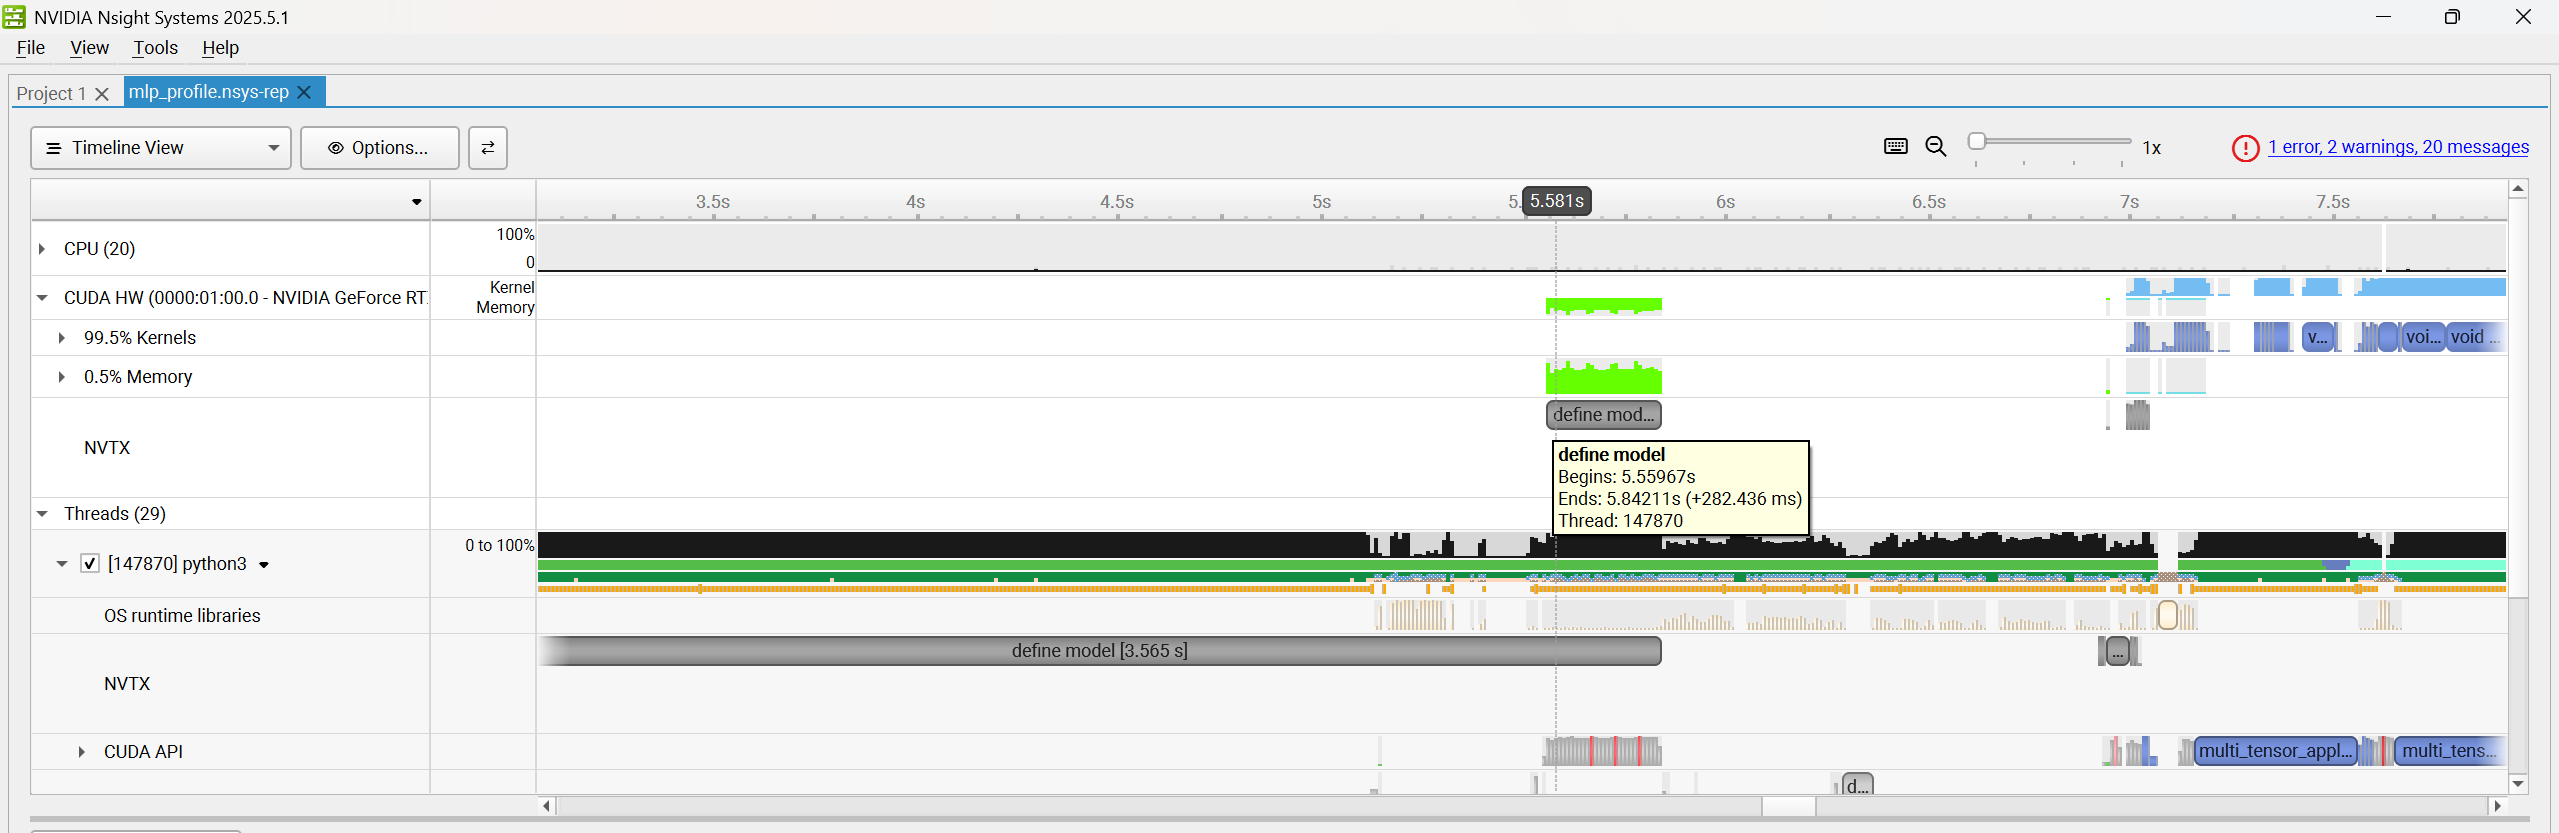
CPU timeline 显示的是 Python 代码执行的时间

GPU timeline 显示的是实际 GPU 硬件执行的时间

 - 两者之间的延迟来自于：

     - CUDA 异步执行机制
     - 首次 GPU 使用的初始化开销
     - CPU 到 GPU 的数据传输时间

##### 在step0 时第一次调用pytorch的结果
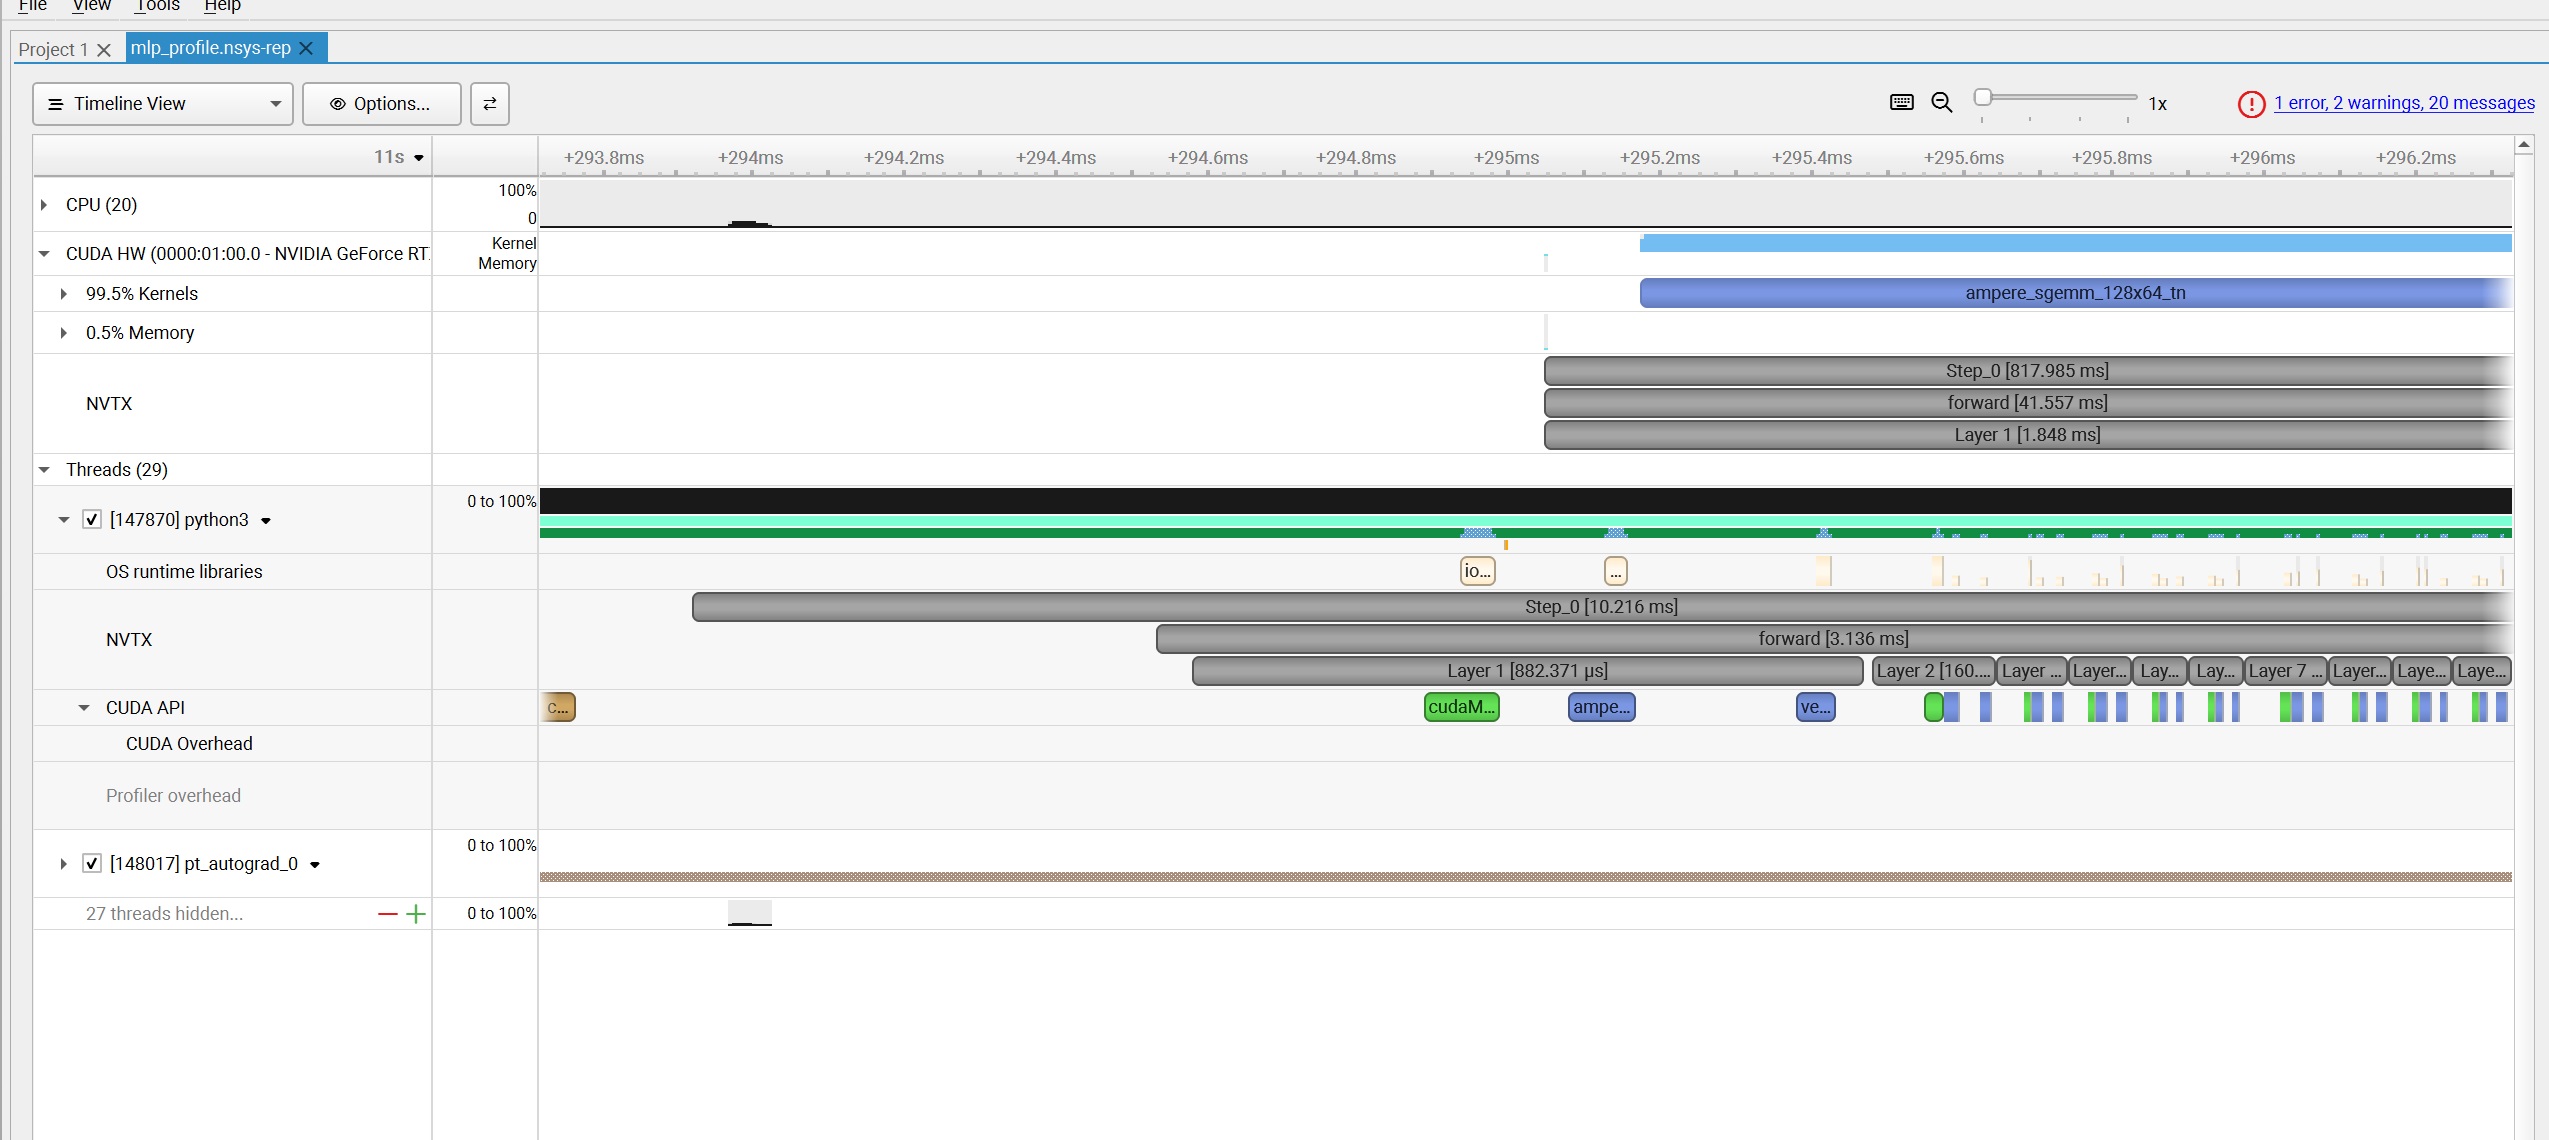
在CPU上第一次使用pytorch进step的时候，就会出现一些初始化的性能开销：即时编译；运行时触发；模块加载，并把代码片段移交到GPU中
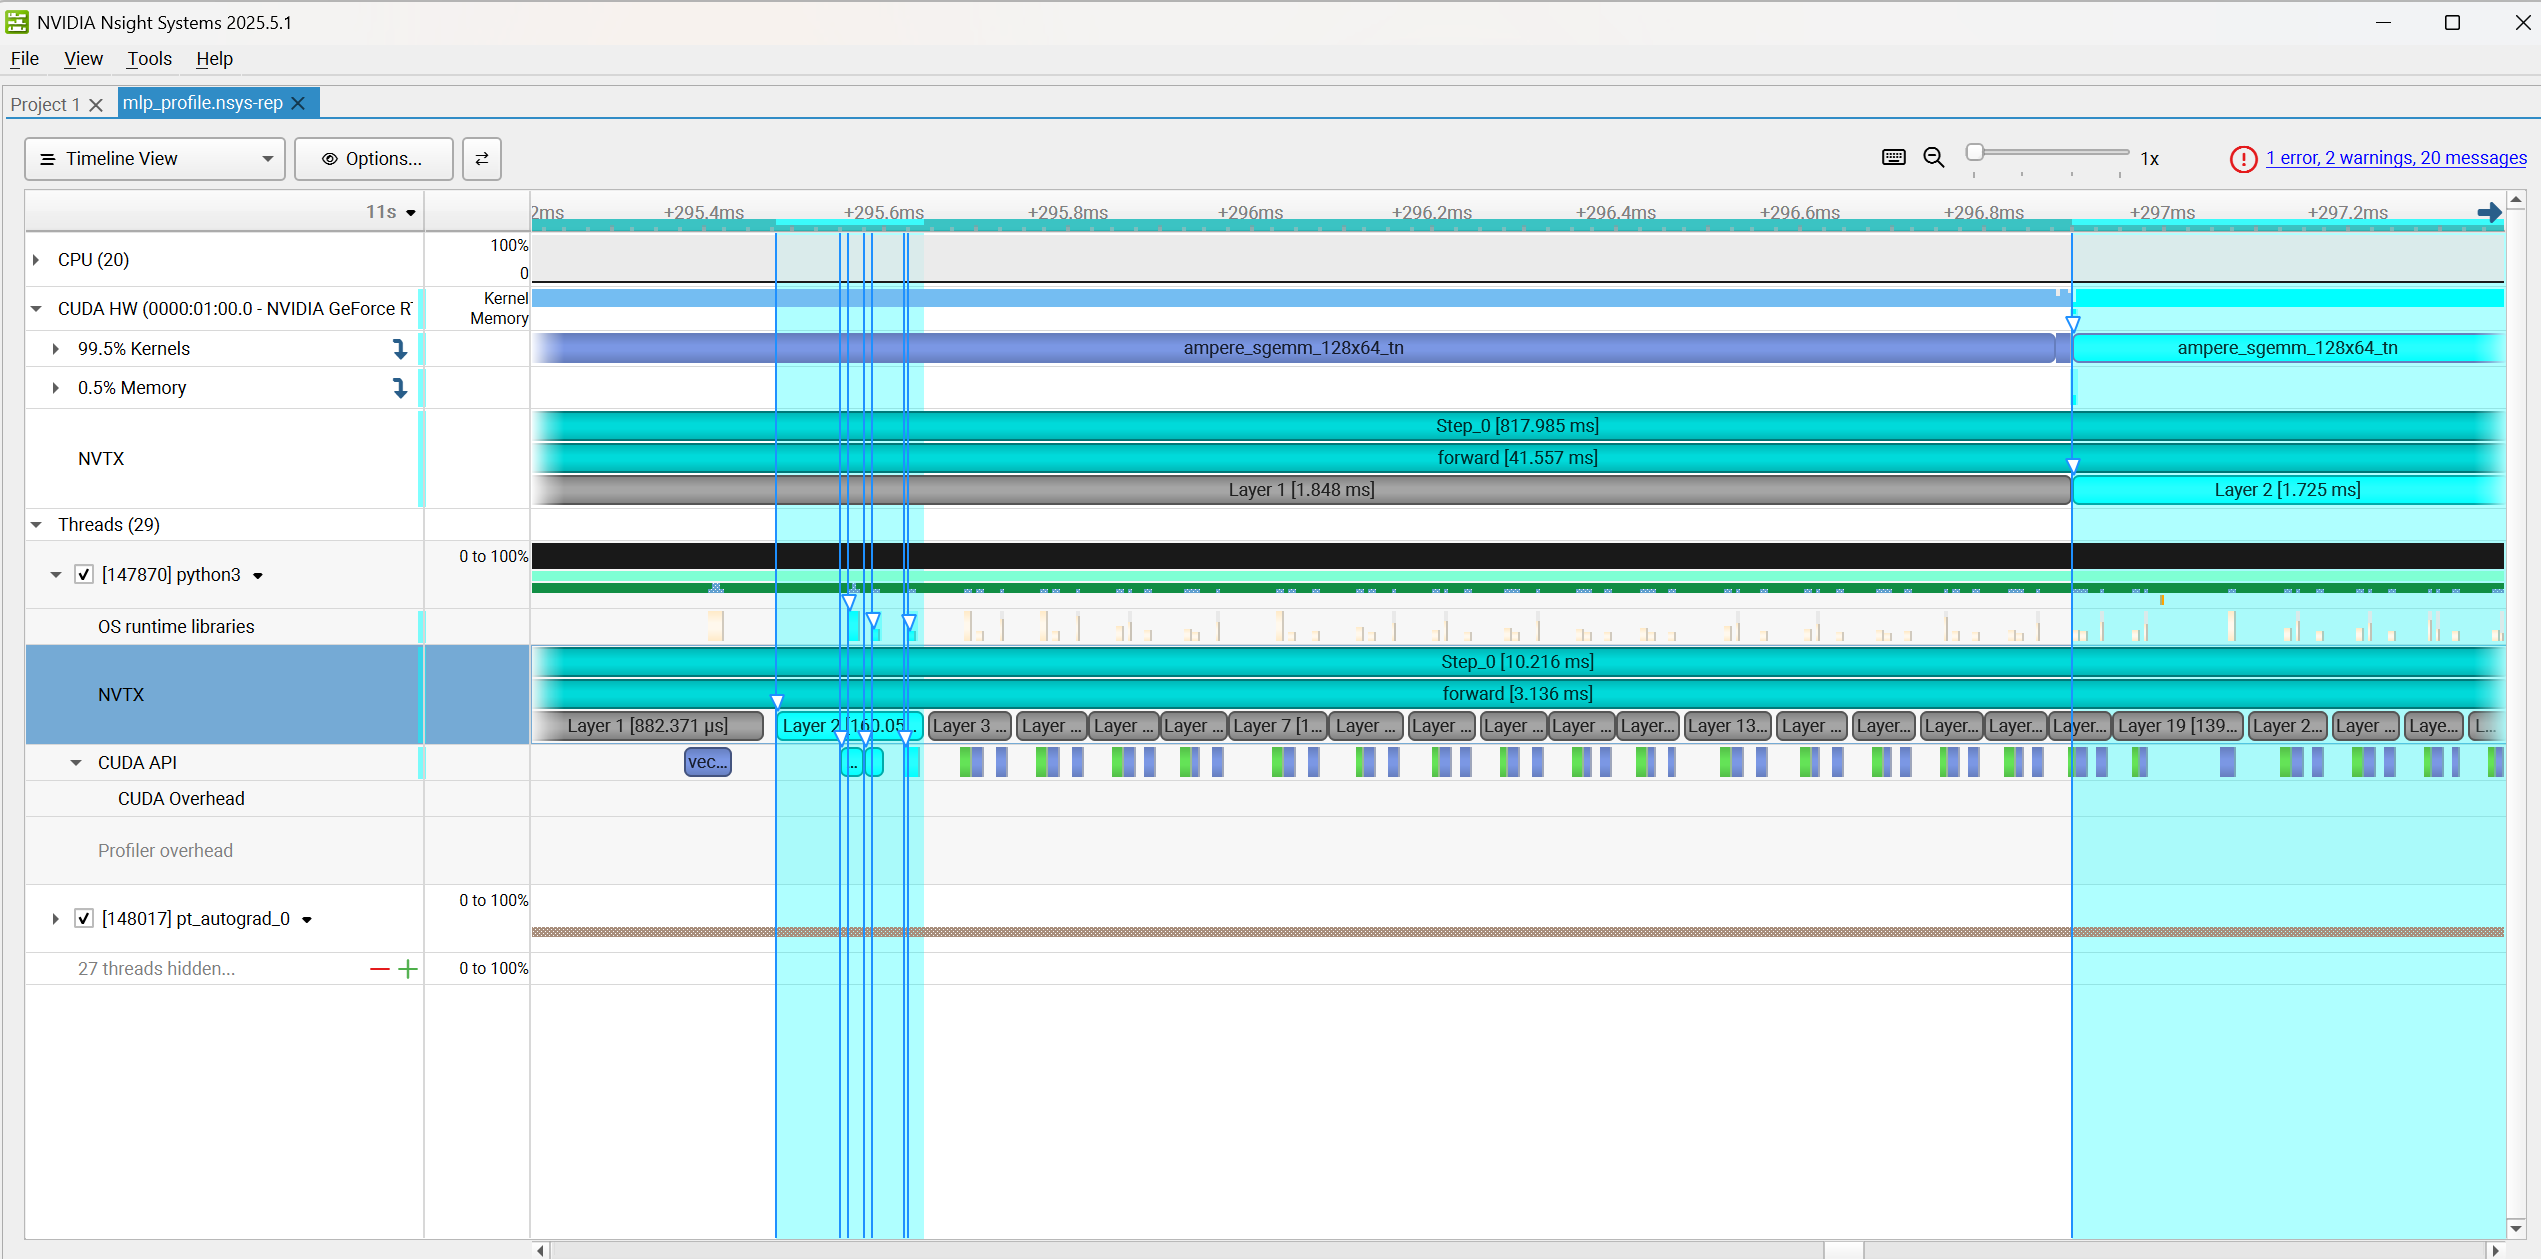
为什么在GPU上比CPU上运行的layer2之后的层要迟，并且更慢，是因为这里的CPU仅仅只起到了发送任务到GPU内核，并启动GPU内核的作用，**此时CPU维护了一个任务队列发送给GPU内核，在任务发送完之后，CPU会尽快向前运行，并不会等待GPU,直到深度差距较大**
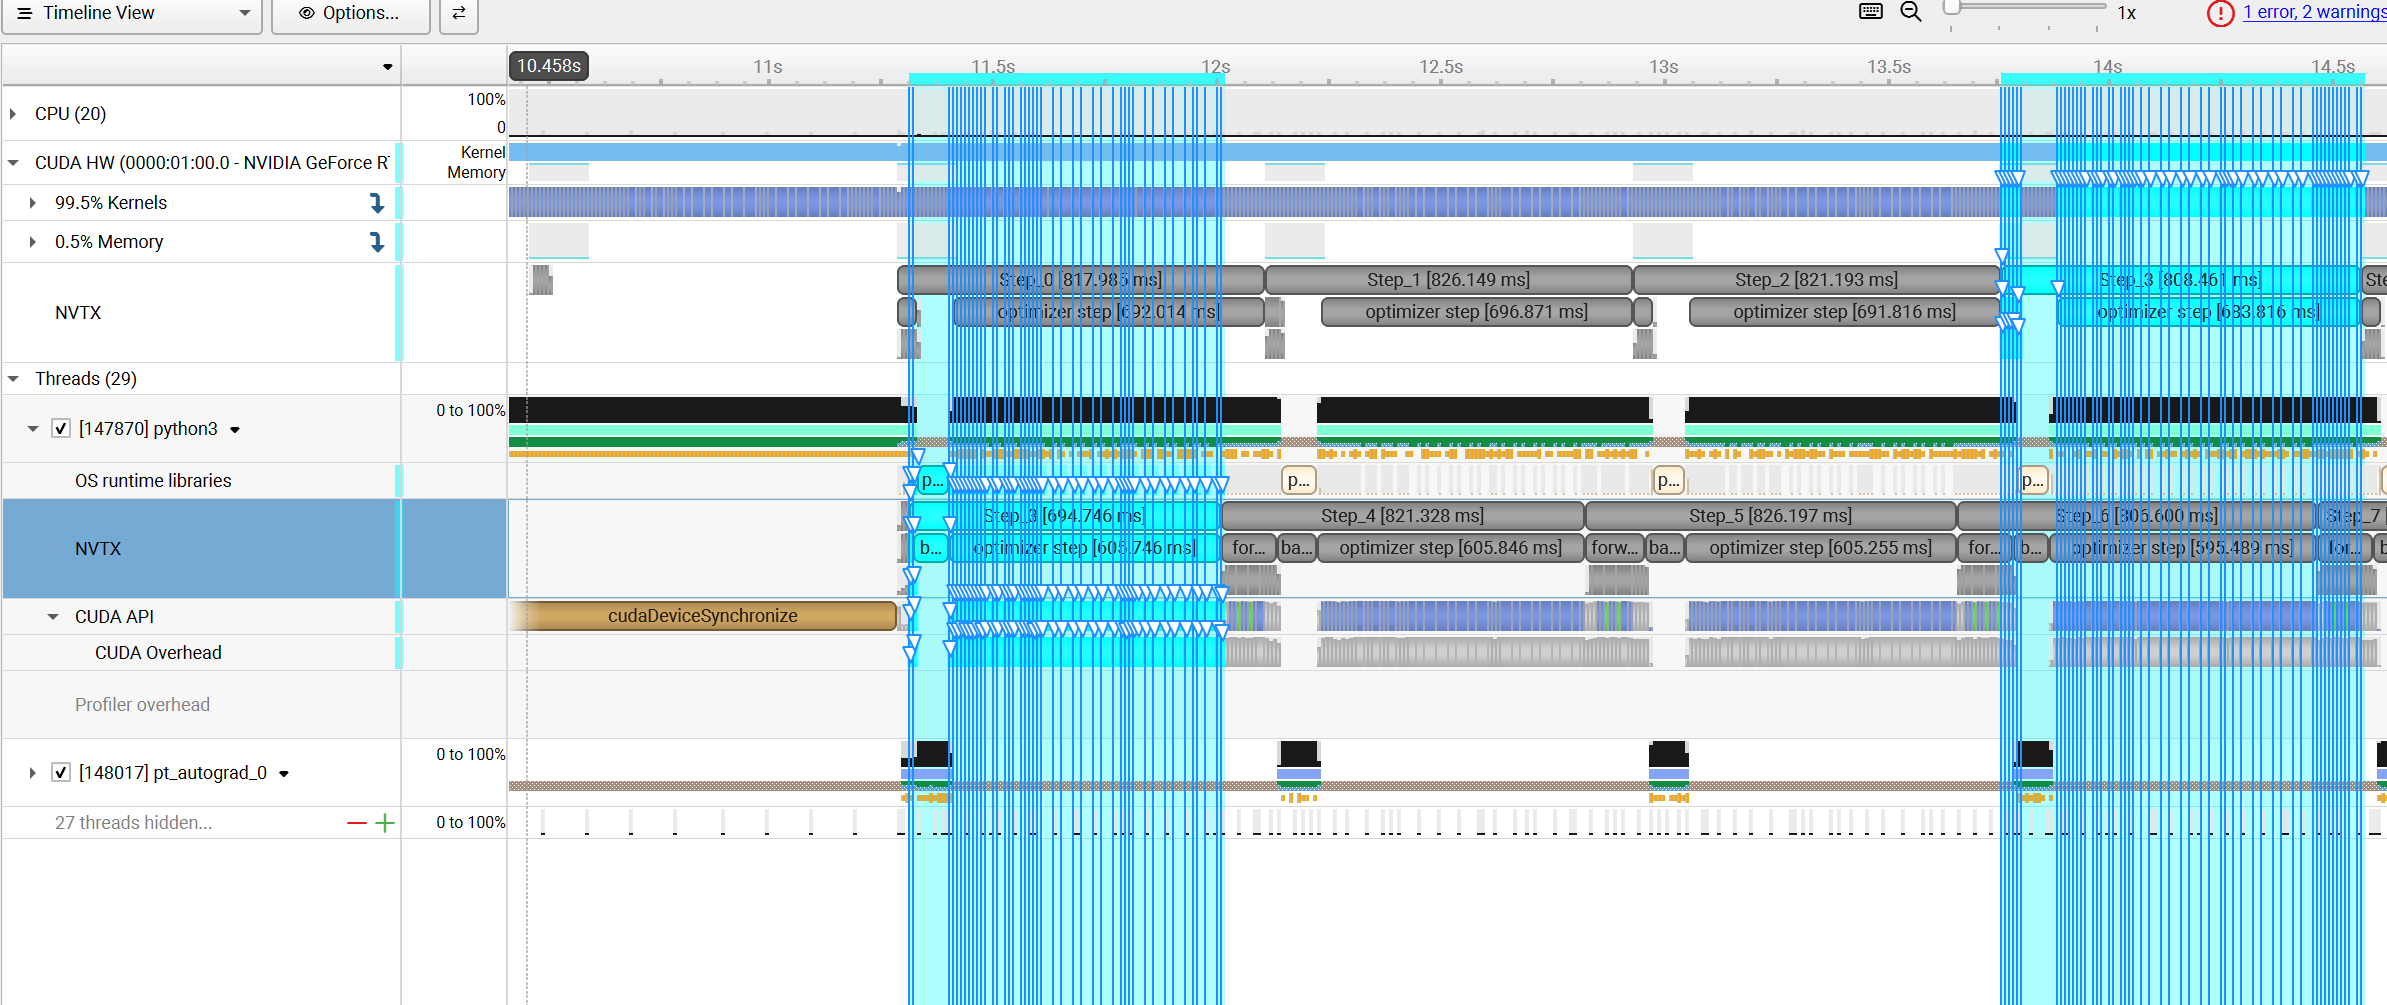
**从上面这张图中可以看出，同样在step3,GPU比CPU慢了3个step**

##### 一个print语句带给GPU的影响
```python
if use_optimizer:
            with nvtx.range("optimizer step"):
                print(f"Step {step}, loss: {y.item()}")  # 打印loss
                optimizer.step()
        
        nvtx.range_pop()
```
这里就意味着CPU必须等待GPU算完，然后在CPU中执行打印函数，所以CPU不可以提前进行分配任务并交给GPU,自己去完成下一个，而是每一步都要与GPU对齐颗粒度
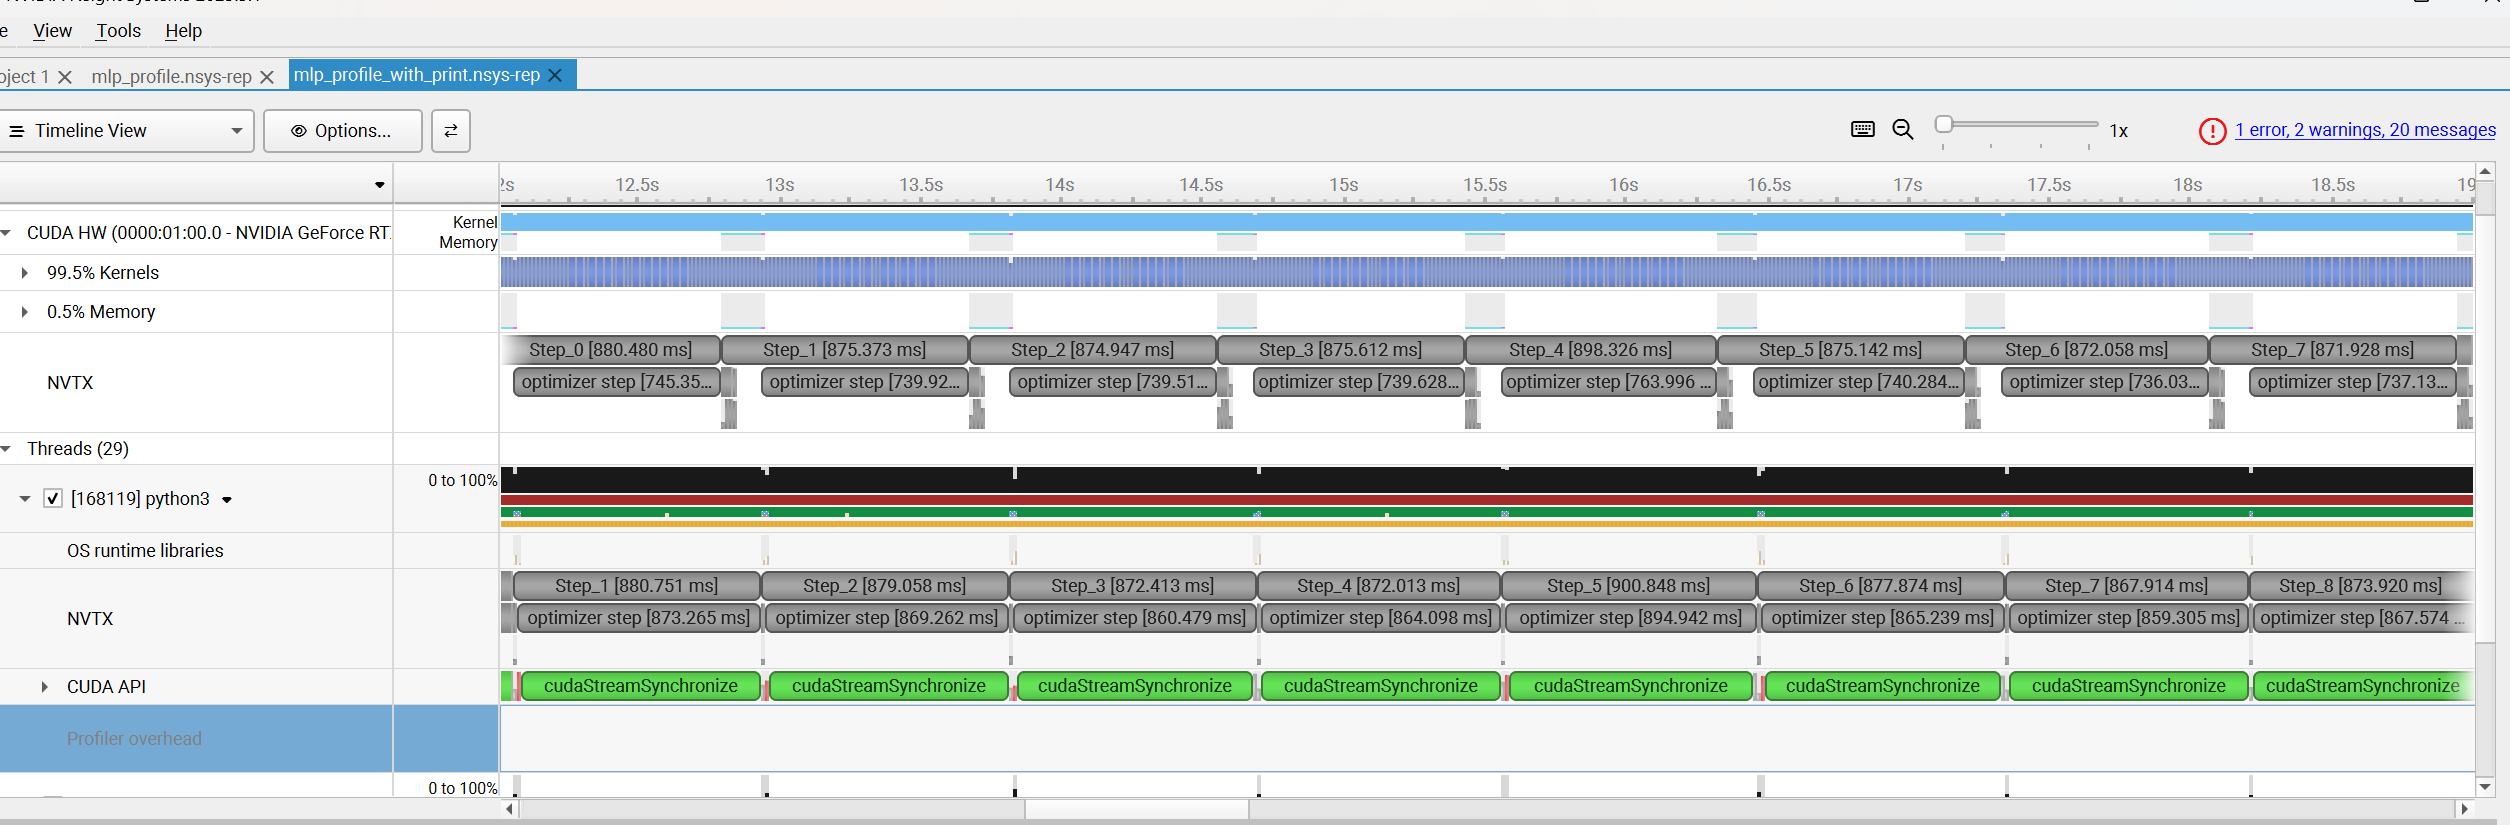
**如上图所示，CPU花了很多时间进行synchronize**

## 写一个kernel
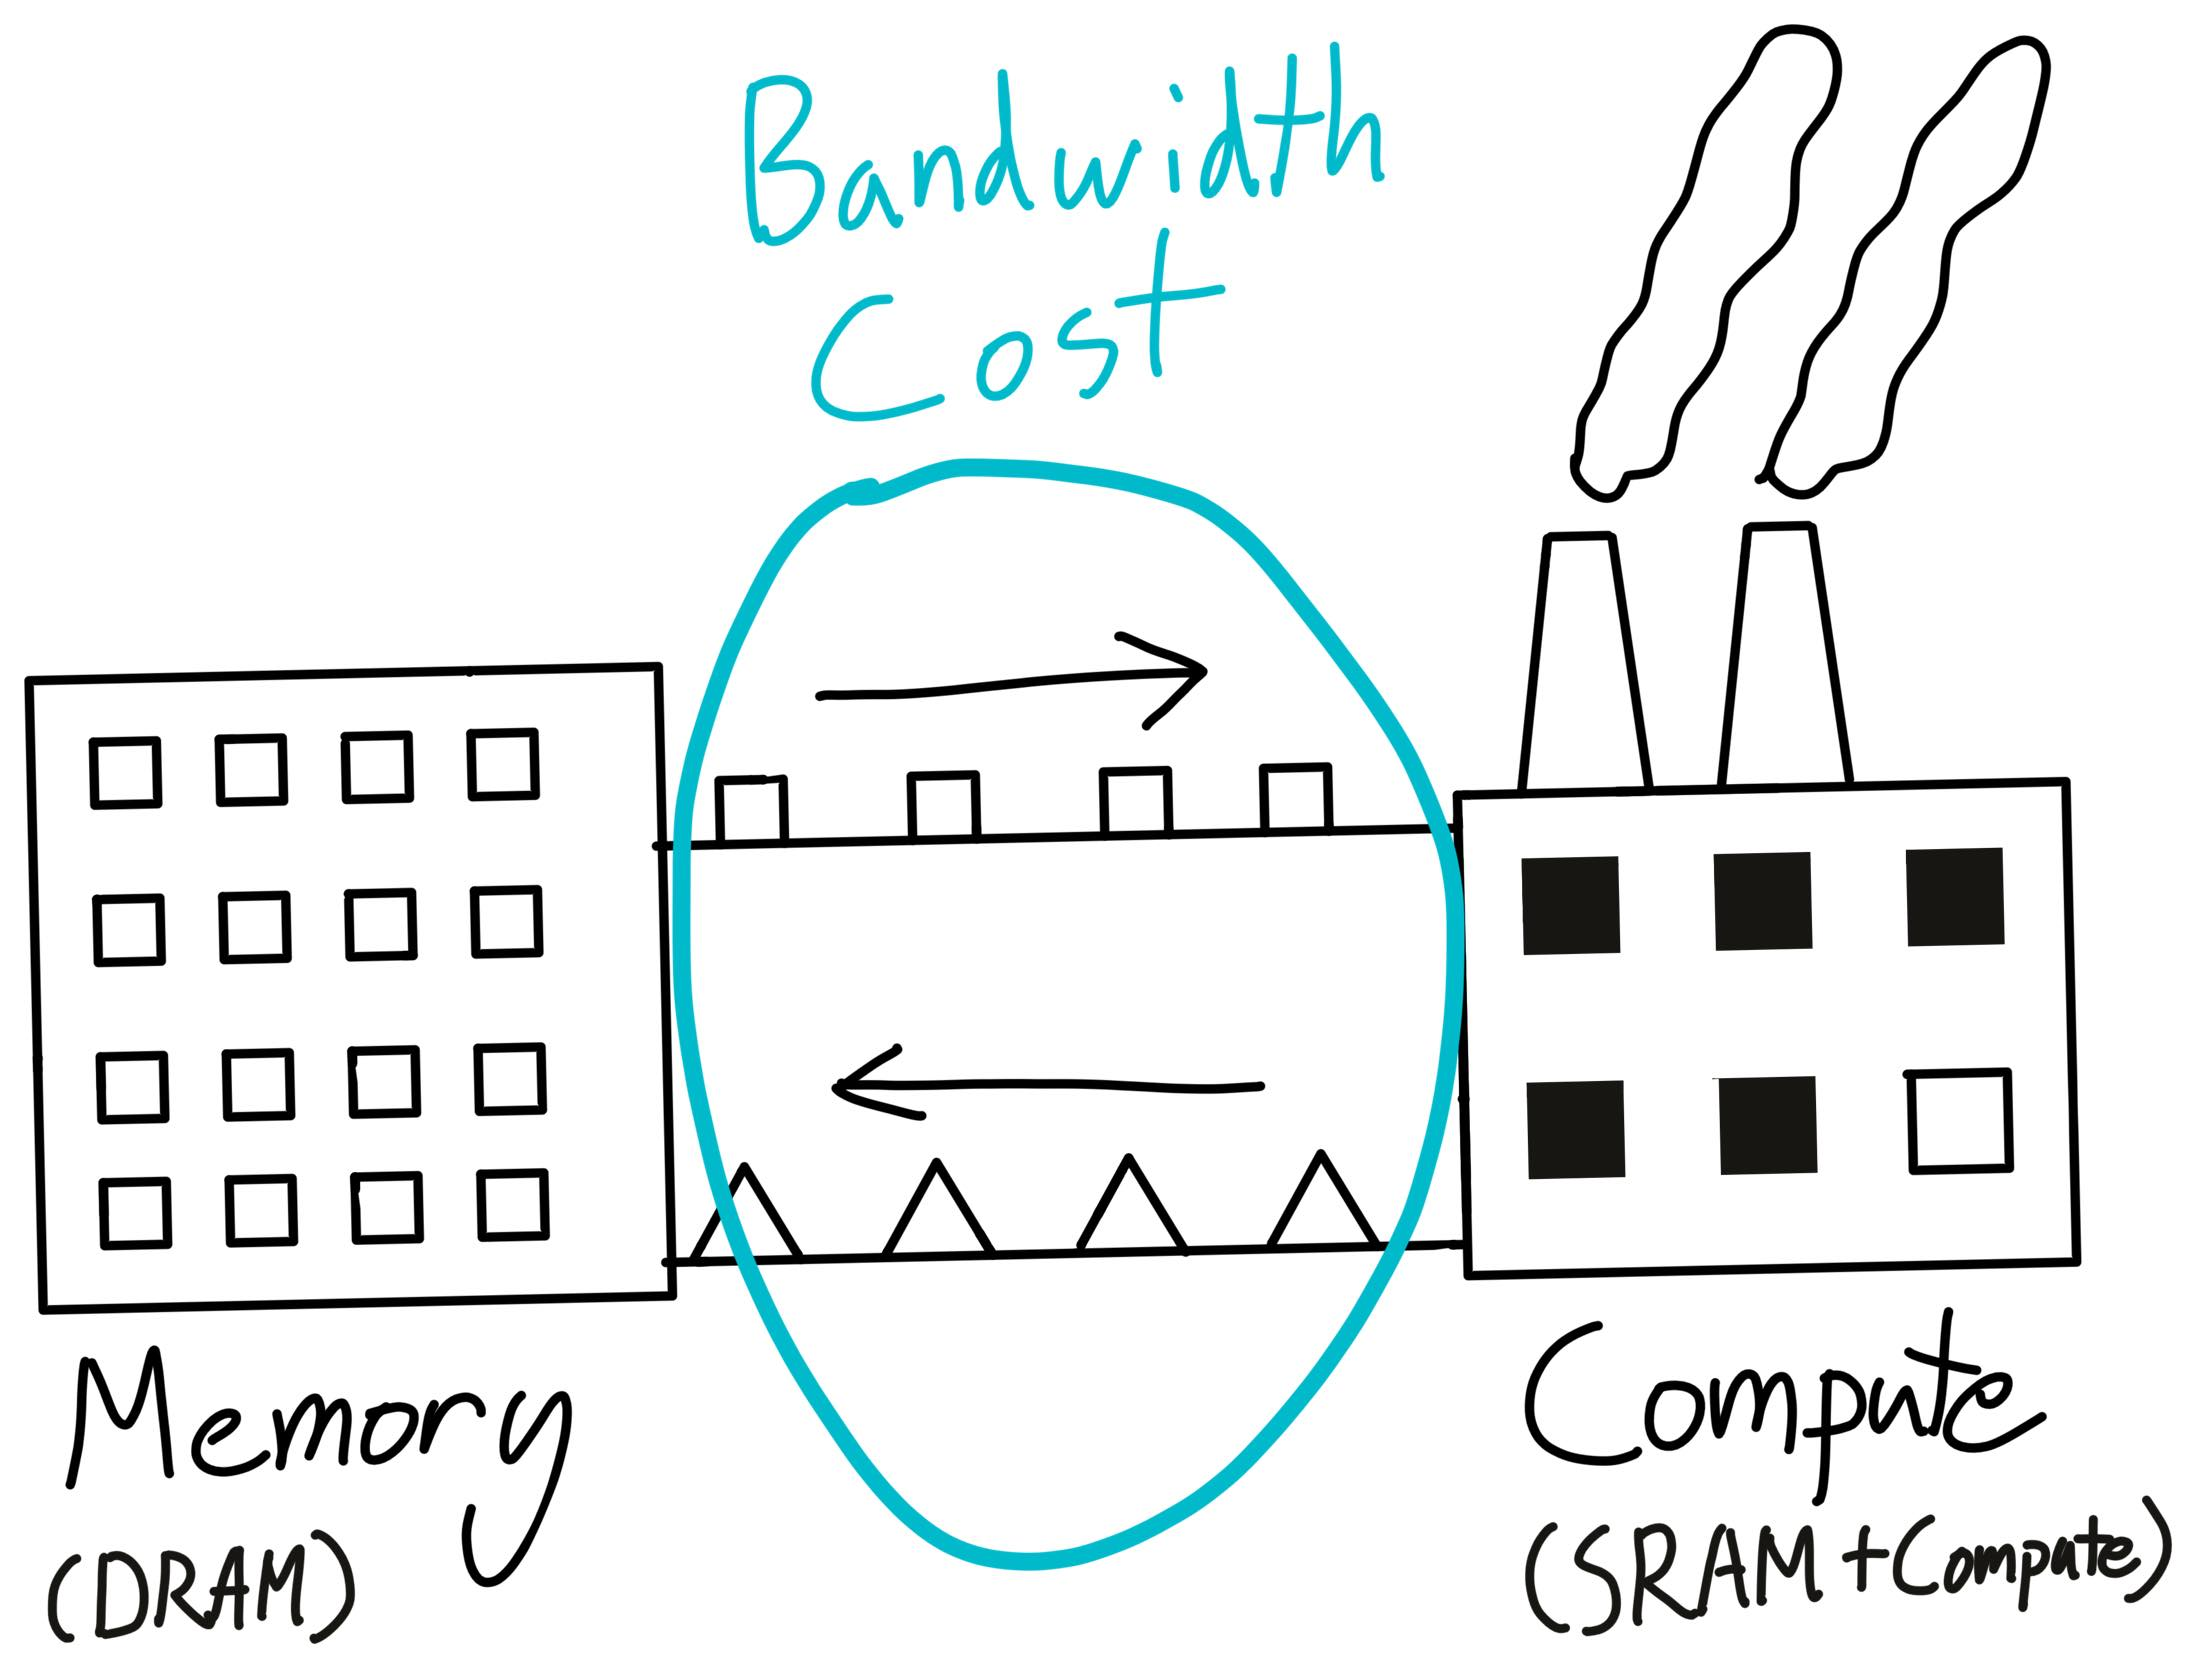
**若未经考虑就写出程序，很可能会造成程序花费大量的时间在转运数据上**
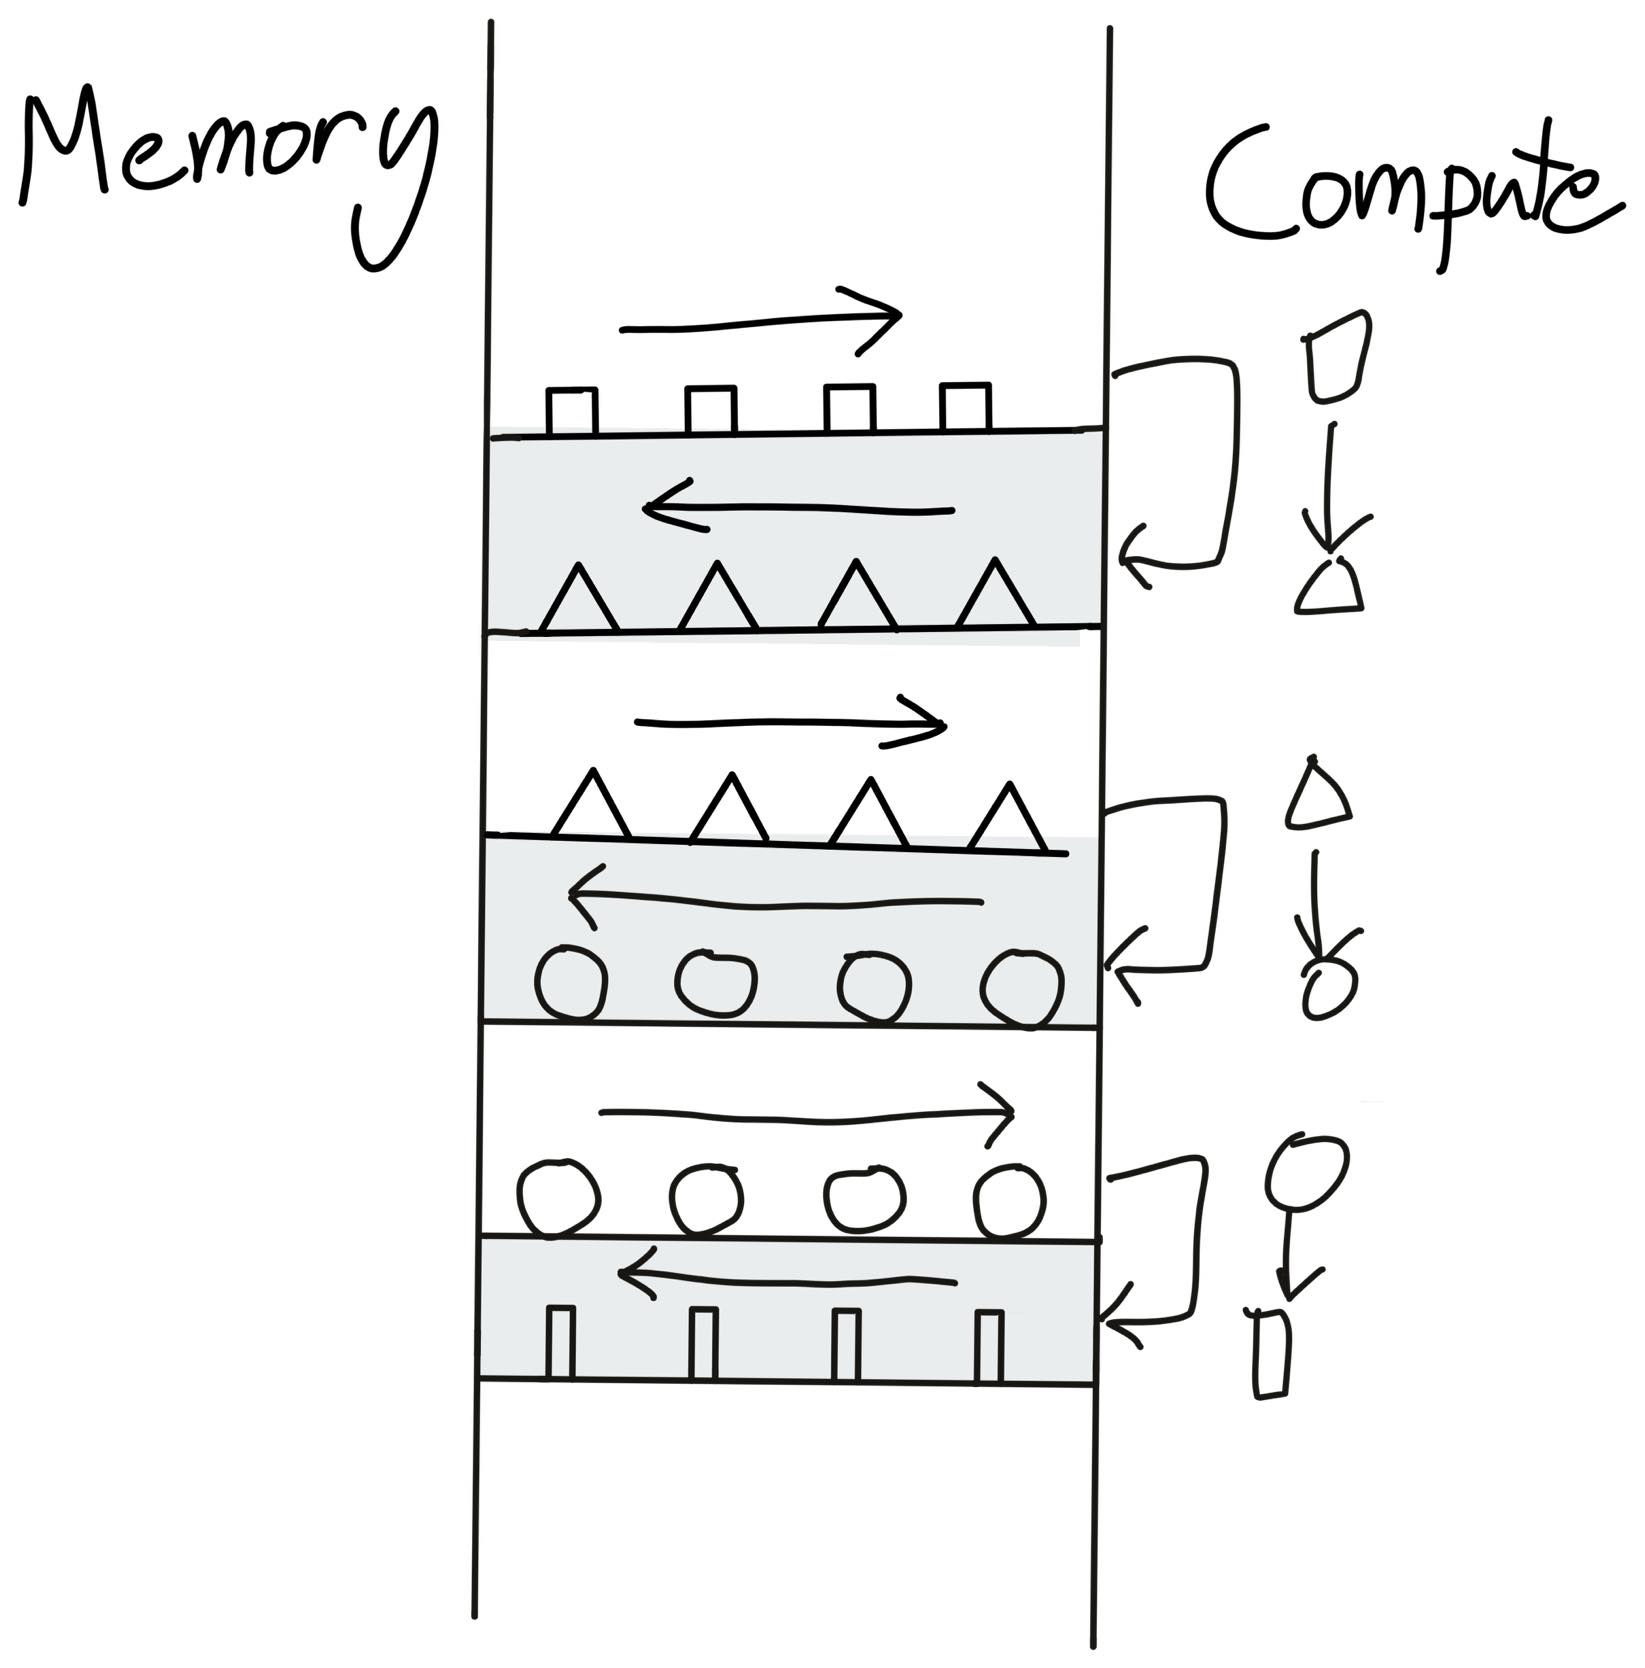
**下面这种情况时理想的转运数据情况，尽量减少运输时间以提高性能**
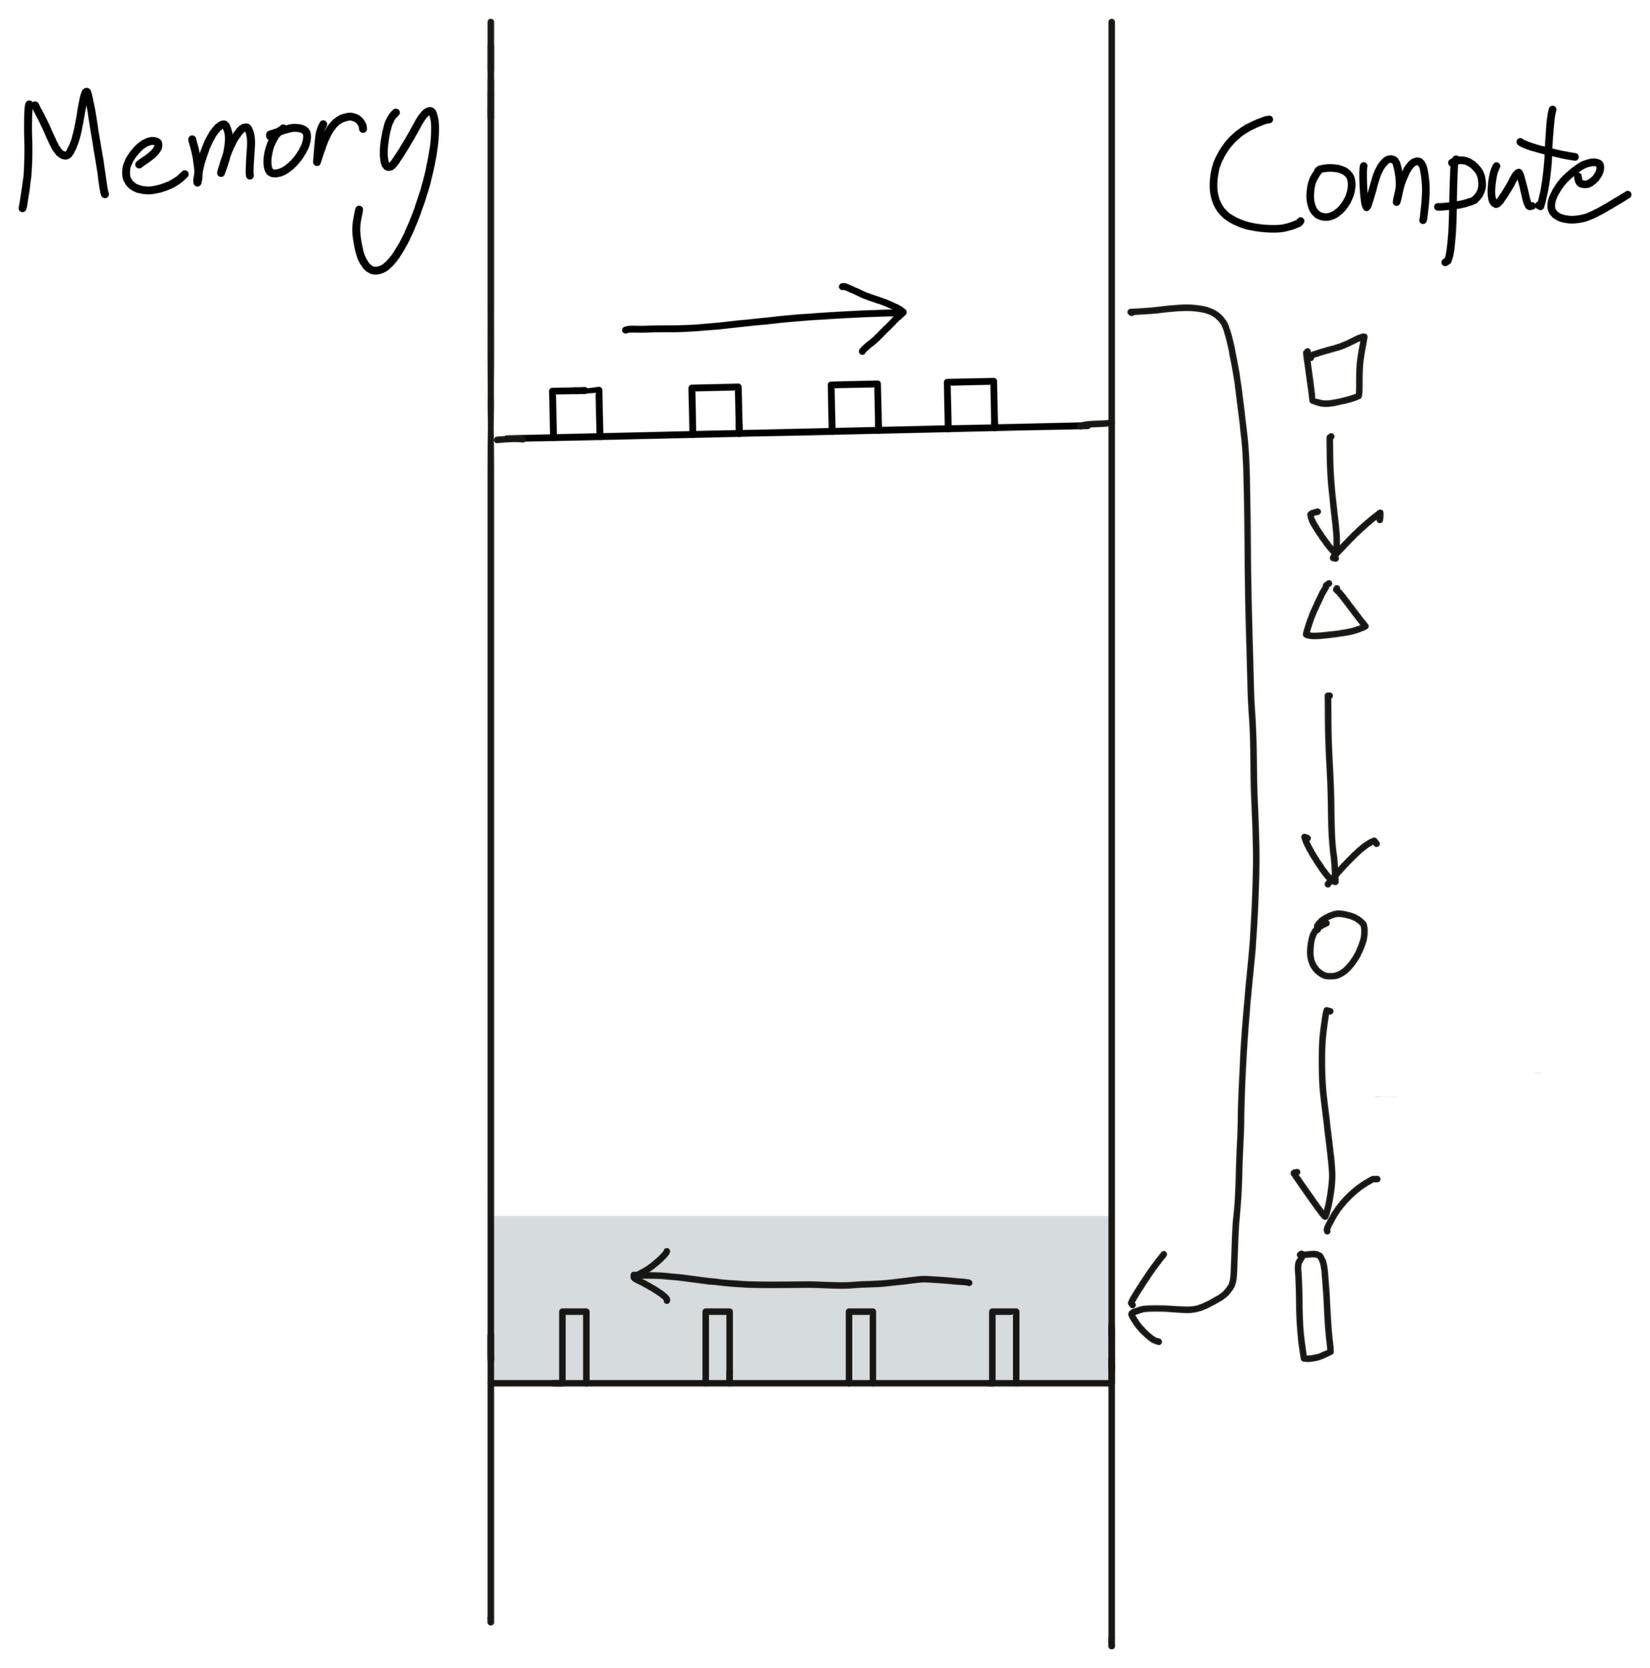

### 实现gelu的两种情况
1. PyTorch 官方的 GELU 实现：
```python
def pytorch_gelu(x: torch.Tensor):
    # Use the tanh approximation to match our implementation
    return torch.nn.functional.gelu(x, approximate="tanh")
```

2. 手动实现的 GELU：
```python
def manual_gelu(x: torch.Tensor):
    return 0.5 * x * (1 + torch.tanh(0.79788456 * (x + 0.044715 * x * x)))
```

从手动实现的gelu可以得知，这个操作可能会分给多个cuda内核进行操作，性能会很慢

**以下是实验结果**
```bash
root@1ee5b610c063:/home/code_backup/code/cs336# python3 try_benchmark.py
manual_gelu mean time: 8.30 ms
pytorch_gelu mean time: 0.08 ms
The fused version (manual_gelu) is significantly faster: 8.30 ms vs 0.08 ms
```
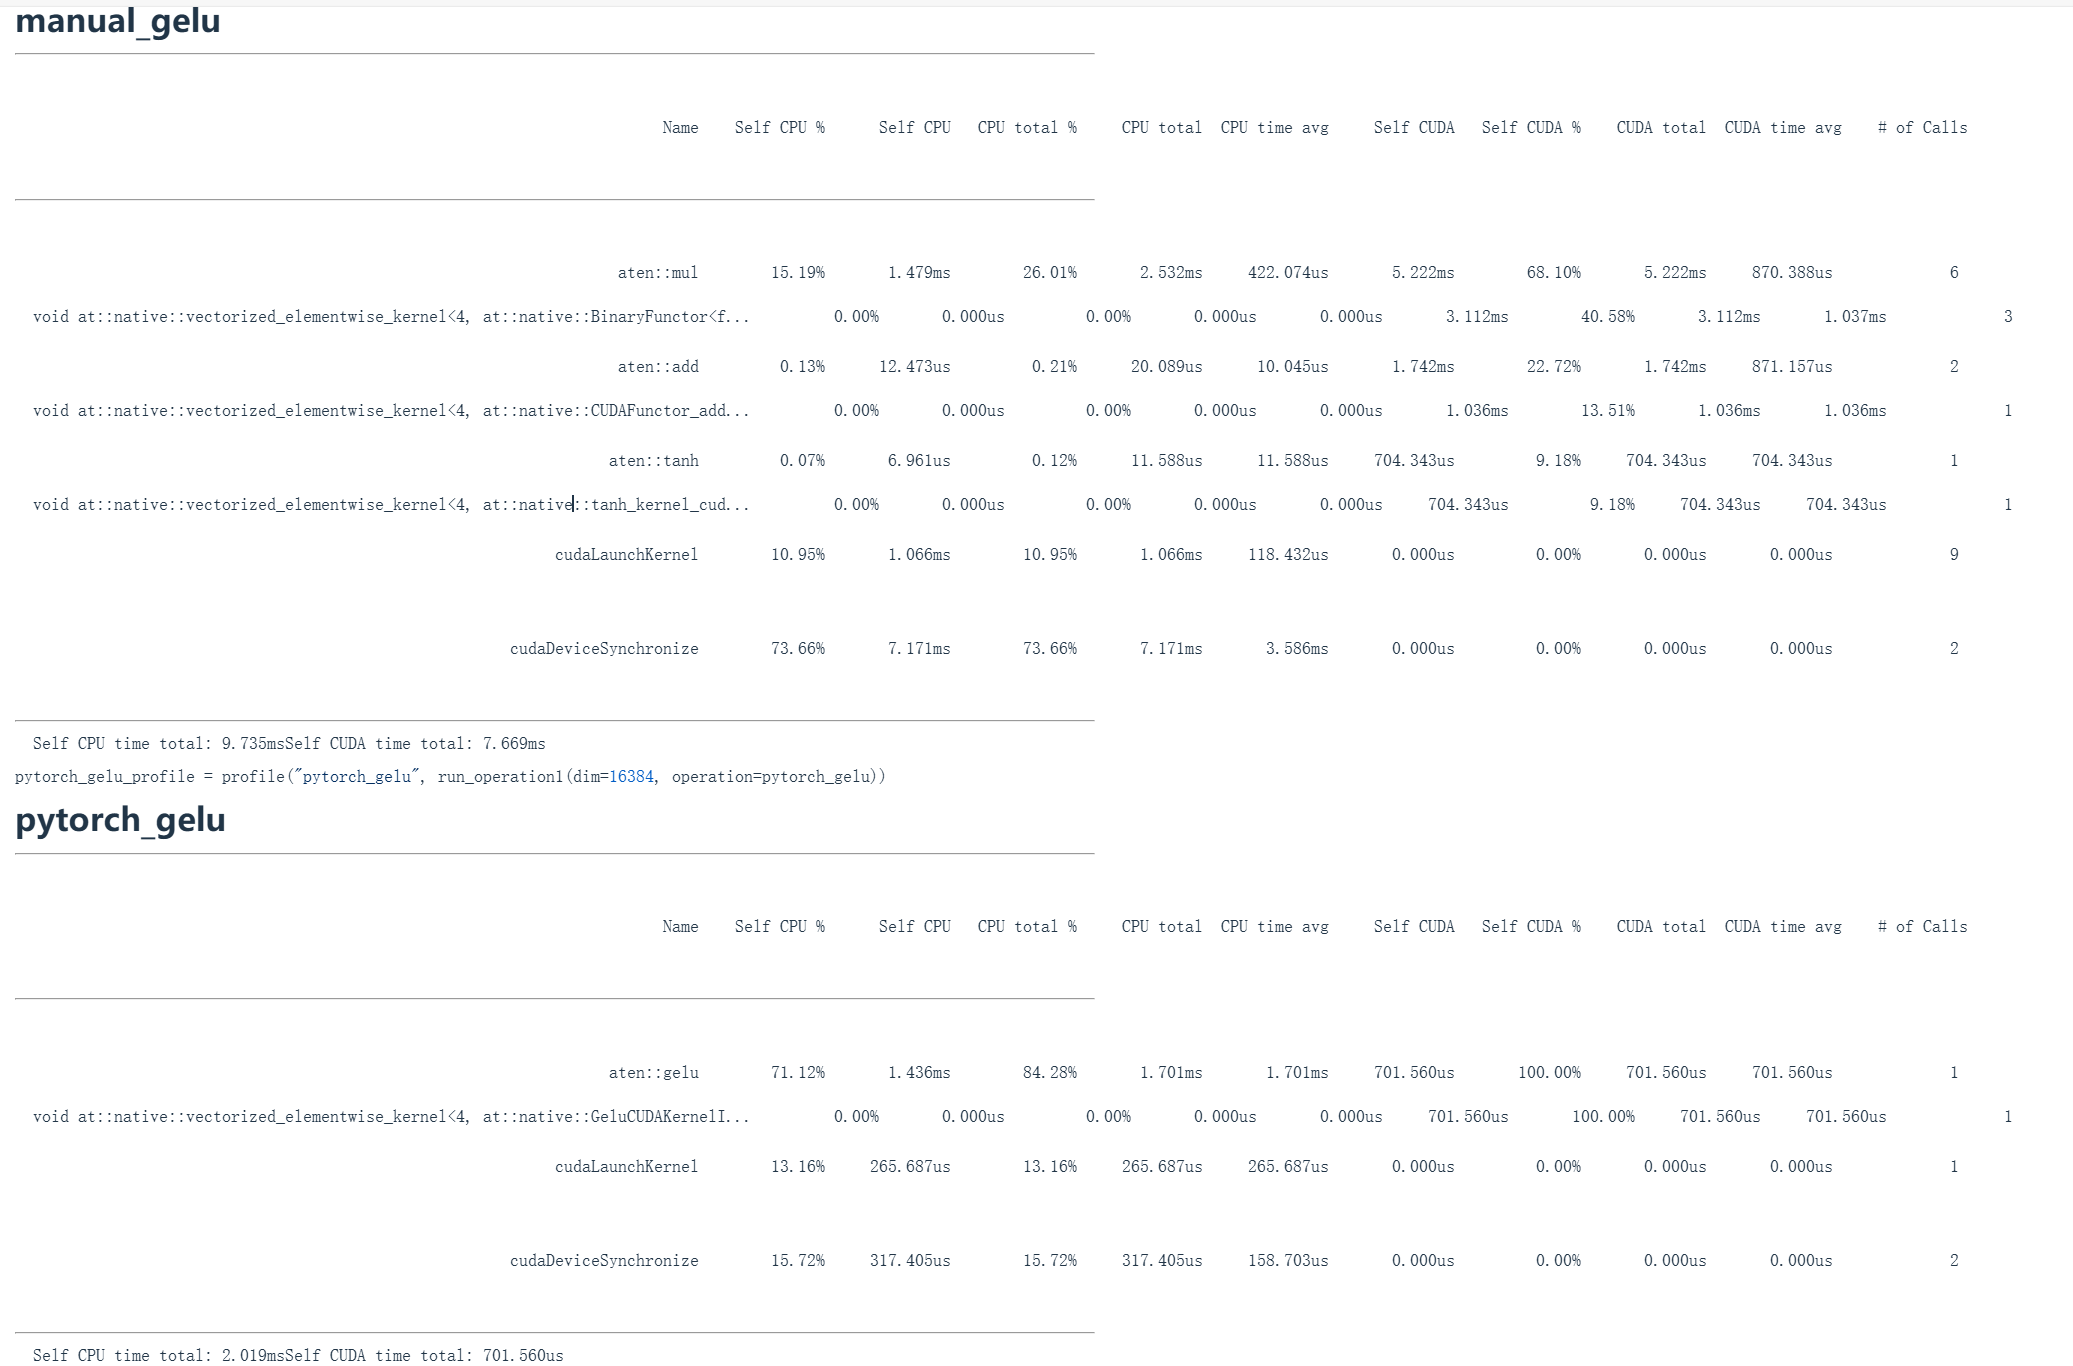
可以观察到，在manual torch调用了好几个cuda内核，但是pytorch的cuda kernel只调用了一个内核，这大大缩短了在各个内核中运行的时间

### 为了优化manual code ,我们使用c++来进行kernel的编写
首先设置环境变量 CUDA_LAUNCH_BLOCKING = 1，这样当 CUDA 程序出现错误时，CUDA 会告诉你错误的具体位置。
```python
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
```


#### 有关计算的函数
```cpp
#include <math.h>
#include <torch/extension.h>
#include <c10/cuda/CUDAException.h>

// CUDA kernel for GELU
//这里的global指的是这个是一个CUDA内核函数
global void gelu_kernel(float* in, float* out, int num_elements) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;  //当前块的位置和块的偏移量
    if (i < num_elements) {
        out[i] = 0.5 * in[i] * (1.0 + tanh(0.79788456 * (in[i] + 0.044715 * in[i] * in[i] * in[i])));
    }
}

// Helper function to compute ceiling of division
inline unsigned int cdiv(unsigned int a, unsigned int b) {
    return (a + b - 1) / b;
}

```

#### CPU调用GPU的核函数
```cpp
torch::Tensor gelu(torch::Tensor x) {
    TORCH_CHECK(x.device().is_cuda());  // 检查张量是否在 CUDA 设备上
    TORCH_CHECK(x.is_contiguous());     // 检查张量是否是连续的

    torch::Tensor y = torch::empty_like(x);  // 创建一个与输入张量相同大小的输出张量(其实是为输出张量分配空间）
    int num_elements = x.numel();  // 获取输入张量的元素数量
    int block_size = 1024;  // 每个线程块的线程数
    int num_blocks = cdiv(num_elements, block_size);  // 计算需要的线程块数量（num_elements除以block_size并向上取整）

    // 启动内核
    gelu_kernel<<<num_blocks, block_size>>>(x.data_ptr<float>(), y.data_ptr<float>(), num_elements);
    C10_CUDA_KERNEL_LAUNCH_CHECK();  // 错误检查

    return y;  // 返回结果张量
}
```

#### 把c++封装到python代码里面
```python
import torch
from torch.utils.cpp_extension import load_inline
import os

def create_cuda_gelu():
    os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  # 设置 CUDA 错误阻塞

    # 读取并准备 CUDA 和 C++ 代码
    cuda_gelu_src = open("gelu.cu").read()
    cpp_gelu_src = "torch::Tensor gelu(torch::Tensor x);"

    # 检查是否有可用的 CUDA
    if not torch.cuda.is_available():
        return None

    # 编译 CUDA 代码并加载为 Python 模块
    module = load_inline(
        cuda_sources=[cuda_gelu_src],
        cpp_sources=[cpp_gelu_src],
        functions=["gelu"],  # 绑定 gelu 函数
        extra_cflags=["-O2"],
        verbose=True,
        name="inline_gelu",
        build_directory="var/cuda_gelu",  # 临时目录
    )

    cuda_gelu = getattr(module, "gelu")  # 获取编译后的函数
    return cuda_gelu  # 返回 CUDA 实现的 gelu 函数

```
##### 得出的结果
```bash
==================================================
Performance Comparison:
==================================================
PyTorch CUDA: 0.09 ms
Custom CUDA: 0.37 ms
Custom CUDA is 0.24x slower than PyTorch CUDA
```

此时由于cuda_gelu是一个GPU内核中运行的，所以速度加快了

### triton
 - 为了不适用c++进行GPU代码的编写，可以使用openai开发的triton语言，这个可以使得你可以使用python语言来控制GPU的细节而不是cuda

 - 使用triton可以实现相比于pytorch性能的提升 
 
| 特性 | CUDA | Triton |
|:---|:---:|:---:|
| **内存合并（Memory Coalescing）** | 手动 | 自动 |
| **共享内存管理** | 手动 | 自动 |
| **SM 内部调度** | 手动 | 自动 |
| **SM 之间调度** | 手动 | 手动 |

### 用triton优化刚刚的代码（benchmark_triton.py）

```python
def triton_gelu(x: torch.Tensor):
    assert x.is_cuda
    assert x.is_contiguous()
    # Allocate output tensor
    y = torch.empty_like(x)
    # Determine grid (elements divided into blocks)
    num_elements = x.numel()
    block_size = 1024  # Number of threads
    num_blocks = triton.cdiv(num_elements, block_size)
    triton_gelu_kernel[(num_blocks,)](x, y, num_elements, BLOCK_SIZE=block_size)
    return y
@triton.jit
def triton_gelu_kernel(x_ptr, y_ptr, num_elements, BLOCK_SIZE: tl.constexpr):
    # Input is at `x_ptr` and output is at `y_ptr`
    #     |        Block 0            |          Block 1          |      ...      |
    #                            BLOCK_SIZE                                 num_elements
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    # Indices where this thread block should operate
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    # Handle boundary
    mask = offsets < num_elements
    # Read
    x = tl.load(x_ptr + offsets, mask=mask)
    # Approx gelu is 0.5 * x * (1 + tanh(sqrt(2/pi) * (x + 0.044715 * x^3)))
    # Compute (tl.tanh doesn't exist, use tanh(a) = (exp(2a) - 1) / (exp(2a) + 1)
    a = 0.79788456 * (x + 0.044715 * x * x * x)
    exp = tl.exp(2 * a)
    tanh = (exp - 1) / (exp + 1)
    y = 0.5 * x * (1 + tanh)
    # Store
    tl.store(y_ptr + offsets, y, mask=mask)
```
**得到的结果**
```bash
root@1ee5b610c063:/home/code_backup/code/cs336# python3 lecture_6/benchmark_triton.py
Warming up Triton kernel...
Correct Triton GELU kernel time (after warmup): 0.5878 ms
PyTorch built-in GELU took 11.0060 ms
Verification successful: Triton and PyTorch outputs match.
root@1ee5b610c063:/home/code_backup/code/cs336# 
```

## triton深入理解
 - triton代码表面上是python代码，但是实际上在编译之后会变成一种叫PTX的基础语言
```bash
.visible .entry triton_gelu_kernel(
.param .u64 .ptr .global .align 1 triton_gelu_kernel_param_0, // 参数 0: 输入张量 x 的全局内存指针
.param .u64 .ptr .global .align 1 triton_gelu_kernel_param_1, // 参数 1: 输出张量 y 的全局内存指针
.param .u32 triton_gelu_kernel_param_2                     // 参数 2: 待处理的总元素数量 num_elements
).reqntid 128, 1, 1{
// .reqntid 128, 1, 1: 指定每个线程块（block）中线程的数量为 128。这是 Triton 编译器根据你的代码和目标硬件自动选择的。

//这些寄存器用于临时存储，这个本地的告诉存储
.reg .pred  %p<5>;    // 声明谓词寄存器，用于条件执行
.reg .b32   %r<49>;  // 声明 32 位通用寄存器，用于整数运算
.reg .f32   %f<113>; // 声明 32 位浮点寄存器，用于单精度浮点运算
.reg .b64   %rd<8>;  // 声明 64 位寄存器，用于存储内存地址和长整数

.loc    1 552 0                         // 以下为调试信息，将 PTX 指令映射回原始 Python 代码的行号
$L__func_begin0:
.loc    1 552 0                         
// %bb.0:
ld.param.u64    %rd5, [triton_gelu_kernel_param_0]; // 从参数列表中加载 x_ptr 到寄存器 %rd5
ld.param.u64    %rd6, [triton_gelu_kernel_param_1]; // 从参数列表中加载 y_ptr 到寄存器 %rd6

$L__tmp0:
.loc    1 557 24                        
// begin inline asm
mov.u32 %r1, %ctaid.x;                  // 获取当前线程块（Block）的 ID，存储在 %r1 中
// end inline asm

.loc    1 558 24                        
shl.b32     %r42, %r1, 10;             // r42 = block_id * 1024，计算当前线程块负责的数据起始索引
ld.param.u32    %r43, [triton_gelu_kernel_param_2]; // 加载总元素数量 num_elements 到 %r43

.loc    1 561 41                        
mov.u32     %r44, %tid.x;              // 获取当前线程在线程块中的 ID
shl.b32     %r45, %r44, 2;             // r45 = thread_id * 4，计算线程在 block 内的字节偏移量（因为 float 占 4 字节）
and.b32     %r46, %r45, 508;            // 复杂计算，用于高效地生成向量化加载的内存地址
.loc    1 561 28                        
or.b32      %r47, %r42, %r46;          // 计算第一个向量化加载的全局起始索引
or.b32      %r48, %r47, 512;           // 计算第二个向量化加载的全局起始索引

.loc    1 564 21                        
setp.lt.s32     %p1, %r47, %r43;         // 边界检查：如果第一个索引小于总元素数，则谓词 %p1 为真
setp.lt.s32     %p2, %r48, %r43;         // 边界检查：如果第二个索引小于总元素数，则谓词 %p2 为真

.loc    1 567 24                        
mul.wide.s32    %rd7, %r47, 4;         // 将索引转换为字节偏移量
add.s64     %rd1, %rd5, %rd7;          // 计算第一个加载操作的绝对内存地址
add.s64     %rd2, %rd1, 2048;          // 计算第二个加载操作的绝对内存地址（2048字节 = 512个float）

.loc    1 567 16                        
// begin inline asm
// 使用谓词 %p1 控制是否执行加载
@%p1 ld.global.v4.b32 { %r2, %r3, %r4, %r5 }, [ %rd1 + 0 ]; // 从 %rd1 地址开始，加载 4 个 32 位值（即 4 个 float）
// end inline asm
mov.b32     %f17, %r2; // 将加载的整数值转换为浮点数，供后续计算使用
mov.b32     %f18, %r3;
mov.b32     %f19, %r4;
mov.b32     %f20, %r5;
// begin inline asm
@%p2 ld.global.v4.b32 { %r6, %r7, %r8, %r9 }, [ %rd2 + 0 ]; // 从 %rd2 地址开始，加载另外 4 个 float
// end inline asm
mov.b32     %f21, %r6;
// ... (类似转换)

.loc    1 571 37                        
mul.f32     %f25, %f17, 0f3D372713;     // 这是 GELU 公式中 0.044715 的浮点表示。执行 x^3 * 0.044715 的第一步
// ... (后续的 mul.f32 和 fma.rn.f32 都是在执行 GELU 公式)
.loc    1 571 41                        
mul.f32     %f33, %f25, %f17;          // 继续执行 x^3
.loc    1 571 26                        
fma.rn.f32  %f41, %f33, %f17, %f17;   // 执行 x + 0.044715 * x^3。fma 是融合乘加指令，高效执行 a*b+c
// ...
.loc    1 572 21                        
fma.rn.f32  %f57, %f41, 0f3F4C422A, %f49; // 执行复杂的 GELU 近似计算，包含多个 fma 步骤
// ...
.loc    1 572 17                        
mul.f32     %f2, %f57, 0f3FB8AA3B;     // 执行 2a
// begin inline asm
ex2.approx.f32 %f1, %f2;                // 使用硬件指令计算 2^x，即 exp(2*a)
// end inline asm
// ... (类似指令执行其他部分)
.loc    1 573 18                        
add.f32     %f65, %f1, 0fBF800000;     // 将 exp(2a) 减去 1
.loc    1 573 30                        
add.f32     %f73, %f1, 0f3F800000;     // 将 exp(2a) 加上 1
.loc    1 573 24                        
// begin inline asm
div.full.f32 %r10, %r11, %r12;          // 执行除法 (exp - 1) / (exp + 1)，计算 tanh
// end inline asm
.loc    1 574 14                        
mul.f32     %f89, %f17, 0f3F000000;     // 将 x 乘以 0.5
// ...
.loc    1 574 23                        
add.f32     %f97, %f81, 0f3F800000;     // tanh + 1
.loc    1 574 19                        
mul.f32     %f105, %f89, %f97;         // 最终计算 y = 0.5 * x * (1 + tanh)
// ...

.loc    1 577 21                        
add.s64     %rd3, %rd6, %rd7;          // 计算输出内存地址
add.s64     %rd4, %rd3, 2048;
.loc    1 577 30                        
mov.b32     %r34, %f105;               // 将最终结果从浮点寄存器移到整数寄存器，准备写入内存

// begin inline asm
// 使用谓词 %p1 控制是否执行存储
@%p1 st.global.v4.b32 [ %rd3 + 0 ], { %r34, %r35, %r36, %r37 }; // 从 %rd3 地址开始，将 4 个 float 写入全局内存
//也就意味着每个线程一次操作四个值
// end inline asm
// ... (类似指令存储另外 4 个 float)

.loc    1 577 4                         
ret;                                    // 核函数结束，返回
$L__tmp1:$L__func_end0:
}
.file   1 "/home/c-thashim/2025/spring2025-lectures/lecture_06.py"
.section    .debug_abbrev
{
// 调试信息部分，此处省略
}
.section    .debug_info
{
// 调试信息部分，此处省略
}
.section    .debug_macinfo  {   }
```

### torch compile
**pytorch对手写代码还有另一种优化的方式，就是使用tprch.compile,可以把手写的代码进行内核融合等优化，这种方法的底层生成的是triton代码**
```python
#Write it in Python and compile it into Triton
compiled_gelu = torch.compile(manual_gelu)
#Check correctness of our implementation.
check_equal(compiled_gelu, manual_gelu)
```

 - 但是`torch.compile`对于硬件的复杂优化不是很擅长，它比较擅长分析矩阵乘法并让其在更佳的内核上进行运算

**还有三种方法在softmax中的运用，其中triton版本是以一行数据以及它的元数据作为一个block的大小**